In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fsl_mrs.utils import mrs_io, fitting
from fsl_mrs.utils.misc import parse_metab_groups

In [3]:
data_path = '../synthetic_fits_2/noise_5/st_l/denoise_031.nii.gz'
data_var_path = '../synthetic_fits_2/noise_5/st_l/denoise_031_var.nii.gz'
data_covar_path = '../synthetic_fits_2/noise_5/st_l/denoise_031_covar'

basis_path = '../data/basis_set'
mask_path = '../noisy_synthetic_data/mask.nii.gz'
wref_path = '../noisy_synthetic_data/wref.nii.gz'

data = mrs_io.read_FID(data_path)
data_var = mrs_io.read_FID(data_var_path)

mrsi = data.mrs(basis_file=basis_path, ref_data=wref_path)

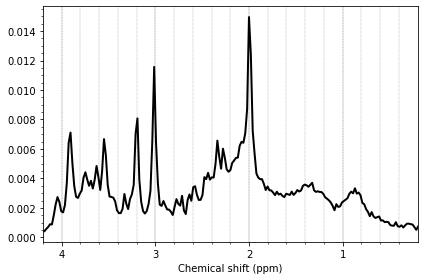

In [4]:
mrs = mrsi.mrs_by_index((24,24,0))
mrs.plot()
var = data_var[24,24,0,:]
covar = np.loadtxt(data_covar_path,dtype=complex)

In [5]:
def make_bs_instantiation(data, var, covar):
    covar_mat = covar.copy() - np.diag(covar) + np.diag(var)
    peturbed_data = \
        np.random.multivariate_normal(data.real,
                                      covar_mat.real/2,
                                      check_valid='ignore') \
        + 1j * np.random.multivariate_normal(data.imag,
                                             covar_mat.real/2,
                                             check_valid='ignore')
    return peturbed_data

In [8]:
reps = 500
Fitargs = {'ppmlim': (0.2,4.2),
           'method': 'Newton',
           'baseline_order': -1,
           'model': 'voigt'}

all_raw_concs = []
for idx in range(reps):
    mrs = mrsi.mrs_by_index((24,24,0))
    mrs.FID = make_bs_instantiation(mrs.FID,var,covar)
    mrs.ignore = ['HG', 'Ala', 'PE']
    mrs.rescaleForFitting()
    metab_groups = parse_metab_groups(mrs, 'combine_all')
    
    res = fitting.fit_FSLModel(mrs, **Fitargs, metab_groups=metab_groups)

    res.combine([['PCho', 'GPC'],['Cr', 'PCr'],['NAA', 'NAAG'],['Glu', 'Gln'],['Glc', 'Tau']])
    
    all_raw_concs.append(pd.Series(res.getConc(), index=res.metabs))

In [9]:
df_concs = pd.concat(all_raw_concs,axis=1)
df_concs

0         1         2         3         4         5    \
Asc       0.001470  0.009297  0.000000  0.009778  0.000000  0.008578   
Asp       0.360397  0.340308  0.332640  0.346626  0.332433  0.341215   
Cr        0.113680  0.116944  0.118542  0.129546  0.117494  0.113733   
GABA      0.185704  0.185783  0.195870  0.197162  0.195007  0.204543   
GPC       0.041609  0.036352  0.037075  0.034704  0.037731  0.038686   
GSH       0.060981  0.060837  0.057379  0.058009  0.059542  0.059798   
Glc       0.007623  0.003540  0.015049  0.005483  0.012191  0.007209   
Gln       0.260034  0.257005  0.252605  0.262947  0.251267  0.261399   
Glu       0.243827  0.240598  0.230576  0.224095  0.234142  0.222242   
Ins       0.210182  0.208495  0.202158  0.207168  0.203450  0.207916   
Lac       0.193921  0.198658  0.196316  0.198096  0.195367  0.199447   
NAA       0.252482  0.258629  0.254008  0.251835  0.258456  0.258603   
NAAG      0.030584  0.030487  0.031249  0.029051  0.030557  0.029761   
PCho      0.017178  0.022316  0.021459  0.024313  0.020326  0.018836   
PCr       0.127141  0.123970  0.119724  0.109581  0.121659  0.125620   
Scyllo    0.015576  0.015521  0.016321  0.018313  0.016454  0.017324   
Tau       0.040596  0.045664  0.033178  0.036887  0.035831  0.045635   
Cr+PCr    0.240821  0.240915  0.238266  0.239127  0.239153  0.239353   
PCho+GPC  0.058787  0.058668  0.058534  0.059017  0.058056  0.057522   
NAA+NAAG  0.283066  0.289116  0.285258  0.280886  0.289013  0.288363   
Glu+Gln   0.503862  0.497602  0.483181  0.487042  0.485409  0.483641   
Glc+Tau   0.048220  0.049205  0.048227  0.042370  0.048022  0.052844   

               6         7         8         9    ...       490       491  \
Asc       0.004247  0.001305  0.003592  0.001597  ...  0.009593  0.002380   
Asp       0.342068  0.344509  0.349597  0.336223  ...  0.337802  0.360983   
Cr        0.120285  0.121821  0.115347  0.113794  ...  0.132547  0.120352   
GABA      0.190685  0.189307  0.201005  0.194547  ...  0.201937  0.174082   
GPC       0.037760  0.035287  0.033615  0.043215  ...  0.037703  0.041863   
GSH       0.058933  0.063929  0.057079  0.061874  ...  0.055351  0.063398   
Glc       0.009183  0.005488  0.013255  0.007553  ...  0.004188  0.004501   
Gln       0.259025  0.258038  0.258138  0.246657  ...  0.258786  0.255956   
Glu       0.237036  0.231897  0.226629  0.237073  ...  0.228120  0.256584   
Ins       0.206992  0.207837  0.207527  0.207945  ...  0.206037  0.212144   
Lac       0.209091  0.201063  0.196782  0.197342  ...  0.204260  0.194548   
NAA       0.255633  0.254956  0.253708  0.254734  ...  0.260842  0.255768   
NAAG      0.032378  0.028496  0.032278  0.033646  ...  0.027722  0.028675   
PCho      0.020916  0.022939  0.025034  0.014688  ...  0.021022  0.017563   
PCr       0.122234  0.121500  0.127190  0.124862  ...  0.110848  0.124581   
Scyllo    0.016464  0.017536  0.016494  0.016108  ...  0.017694  0.018491   
Tau       0.039066  0.042247  0.039037  0.039878  ...  0.040213  0.038138   
Cr+PCr    0.242519  0.243322  0.242537  0.238656  ...  0.243396  0.244933   
PCho+GPC  0.058676  0.058226  0.058649  0.057903  ...  0.058725  0.059426   
NAA+NAAG  0.288011  0.283452  0.285987  0.288380  ...  0.288564  0.284442   
Glu+Gln   0.496061  0.489935  0.484767  0.483729  ...  0.486907  0.512540   
Glc+Tau   0.048249  0.047735  0.052292  0.047431  ...  0.044401  0.042638   

               492       493       494       495       496       497  \
Asc       0.007089  0.009077  0.009202  0.000000  0.000000  0.005621   
Asp       0.332156  0.345941  0.346586  0.352407  0.330169  0.351280   
Cr        0.126677  0.122672  0.120333  0.118108  0.121846  0.125671   
GABA      0.183525  0.190164  0.188303  0.181965  0.180179  0.187977   
GPC       0.034994  0.036681  0.036760  0.036384  0.039156  0.033819   
GSH       0.057799  0.057662  0.061056  0.061138  0.061770  0.058282   
Glc       0.011552  0.009990  0.007172  0.006737  0.006410  0.011684   
Gln       

In [35]:
(df_concs.T.iloc[index]-df_concs.T.mean()).pow(2).mean().pow(0.5).divide(df_concs.T.mean())

Asc         0.922578
Asp         0.028452
Cr          0.047691
GABA        0.031388
GPC         0.056174
GSH         0.044000
Glc         0.455512
Gln         0.023971
Glu         0.031280
Ins         0.010625
Lac         0.023419
NAA         0.012572
NAAG        0.067518
PCho        0.107730
PCr         0.047993
Scyllo      0.056962
Tau         0.101015
Cr+PCr      0.009684
PCho+GPC    0.012081
NAA+NAAG    0.009734
Glu+Gln     0.016118
Glc+Tau     0.070522
dtype: float64

In [36]:
rng = np.random.default_rng()
number_of_samples = [10, 20, 30, 40, 50, 100, 200]
reps_draw = 500
stds = np.zeros((df_concs.shape[0],len(number_of_samples),reps_draw))
rmse = np.zeros((df_concs.shape[0],len(number_of_samples),reps_draw))
possible_index = np.arange(0,500)
for sdx,samp in enumerate(number_of_samples):
    for rdx in range(reps_draw):
        index = rng.choice(possible_index,size=samp,replace=False)
        stds[:,sdx,rdx] = df_concs.T.iloc[index].std().to_numpy()
        rmse[:,sdx,rdx] = (df_concs.T.iloc[index]-df_concs.T.mean()).pow(2).mean().pow(0.5).divide(df_concs.T.mean()).to_numpy()

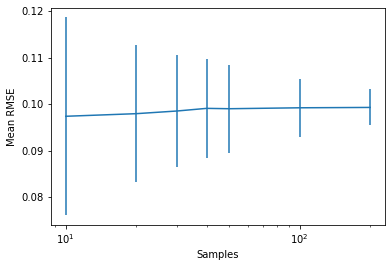

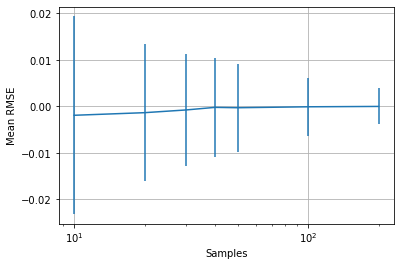

In [51]:
# Plot average NRMSE
plt.errorbar(number_of_samples,rmse.mean(axis=2).mean(axis=0),rmse.std(axis=2).mean(axis=0))
plt.xlabel('Samples')
plt.ylabel('Mean RMSE')
plt.xscale('log')
plt.show()

plt.errorbar(number_of_samples,rmse.mean(axis=2).mean(axis=0) - rmse.mean(axis=2).mean(axis=0)[-1] ,rmse.std(axis=2).mean(axis=0))
plt.xlabel('Samples')
plt.ylabel('Mean RMSE')
plt.xscale('log')
plt.grid()
plt.show()